# Weather-Adjusted Ridership Analysis

**Goal**: Isolate the true growth trend of Citi Bike by controlling for:
- Temperature
- Precipitation
- Day of week
- Holidays
- Seasonality

This allows us to see: **"How much has ridership grown, independent of weather?"**

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

con = duckdb.connect()
print("Connected to DuckDB")

Connected to DuckDB


## 1. Build Daily Dataset with Weather & Calendar Features

In [2]:
# Get daily trip counts with all weather and calendar features
daily = con.execute("""
    SELECT 
        DATE(t.started_at) as date,
        COUNT(*) as trips,
        
        -- Weather features
        AVG(w.temperature_2m) as temp_c,
        AVG(w.apparent_temperature) as feels_like_c,
        MAX(w.precipitation) as max_precip_mm,
        SUM(CASE WHEN w.precipitation > 0 THEN 1 ELSE 0 END) as rainy_hours,
        AVG(w.wind_speed_10m) as wind_kmh,
        AVG(w.relative_humidity_2m) as humidity,
        
        -- Calendar features
        EXTRACT(DOW FROM DATE(t.started_at)) as dow,
        EXTRACT(MONTH FROM DATE(t.started_at)) as month,
        EXTRACT(YEAR FROM DATE(t.started_at)) as year,
        EXTRACT(DAYOFYEAR FROM DATE(t.started_at)) as day_of_year,
        
        -- Daylight
        AVG(d.daylight_hours) as daylight_hours,
        
        -- Holiday
        MAX(CASE WHEN h.holiday_name IS NOT NULL THEN 1 ELSE 0 END) as is_holiday
        
    FROM '../data/processed/*.parquet' t
    LEFT JOIN '../data/weather/hourly_weather.parquet' w
        ON DATE_TRUNC('hour', t.started_at) = w.datetime
    LEFT JOIN '../data/weather/daily_weather.parquet' d
        ON DATE(t.started_at) = d.date
    LEFT JOIN '../data/weather/holidays.parquet' h
        ON DATE(t.started_at) = h.date
    GROUP BY 1
    ORDER BY 1
""").fetchdf()

# Convert to Fahrenheit
daily['temp_f'] = daily['temp_c'] * 9/5 + 32
daily['feels_like_f'] = daily['feels_like_c'] * 9/5 + 32

# Is weekend?
daily['is_weekend'] = daily['dow'].isin([0, 6]).astype(int)

# Days since start (for trend)
daily['date'] = pd.to_datetime(daily['date'])
daily['days_since_start'] = (daily['date'] - daily['date'].min()).dt.days

print(f"Dataset: {len(daily):,} days")
print(f"Date range: {daily['date'].min().date()} to {daily['date'].max().date()}")
print(f"Total trips: {daily['trips'].sum():,}")
daily.head()

Dataset: 4,557 days
Date range: 2013-06-01 to 2025-11-30
Total trips: 287,562,477


,date,trips,temp_c,feels_like_c,max_precip_mm,rainy_hours,wind_kmh,humidity,dow,month,year,day_of_year,daylight_hours,is_holiday,temp_f,feels_like_f,is_weekend,days_since_start
0,2013-06-01,8427,28.035030,29.909149,0.0,0.0,12.056722,55.845378,6,6,2013,152,14.916667,0,82.463054,85.836468,1,0
1,2013-06-02,15607,27.305331,29.216256,1.9,4263.0,14.514250,61.548792,0,6,2013,153,14.916667,0,81.149596,84.589260,1,1
2,2013-06-03,7359,22.542927,24.681791,6.0,727.0,4.298111,73.791820,1,6,2013,154,14.950000,0,72.577269,76.427224,0,2
3,2013-06-04,15180,19.450441,17.716713,0.0,0.0,12.095705,47.111462,2,6,2013,155,14.966667,0,67.010794,63.890083,0,3
4,2013-06-05,15250,18.656970,17.829521,0.0,0.0,9.506990,57.999344,3,6,2013,156,14.983333,0,65.582547,64.093138,0,4


## 2. Visualize Raw Weather Effects

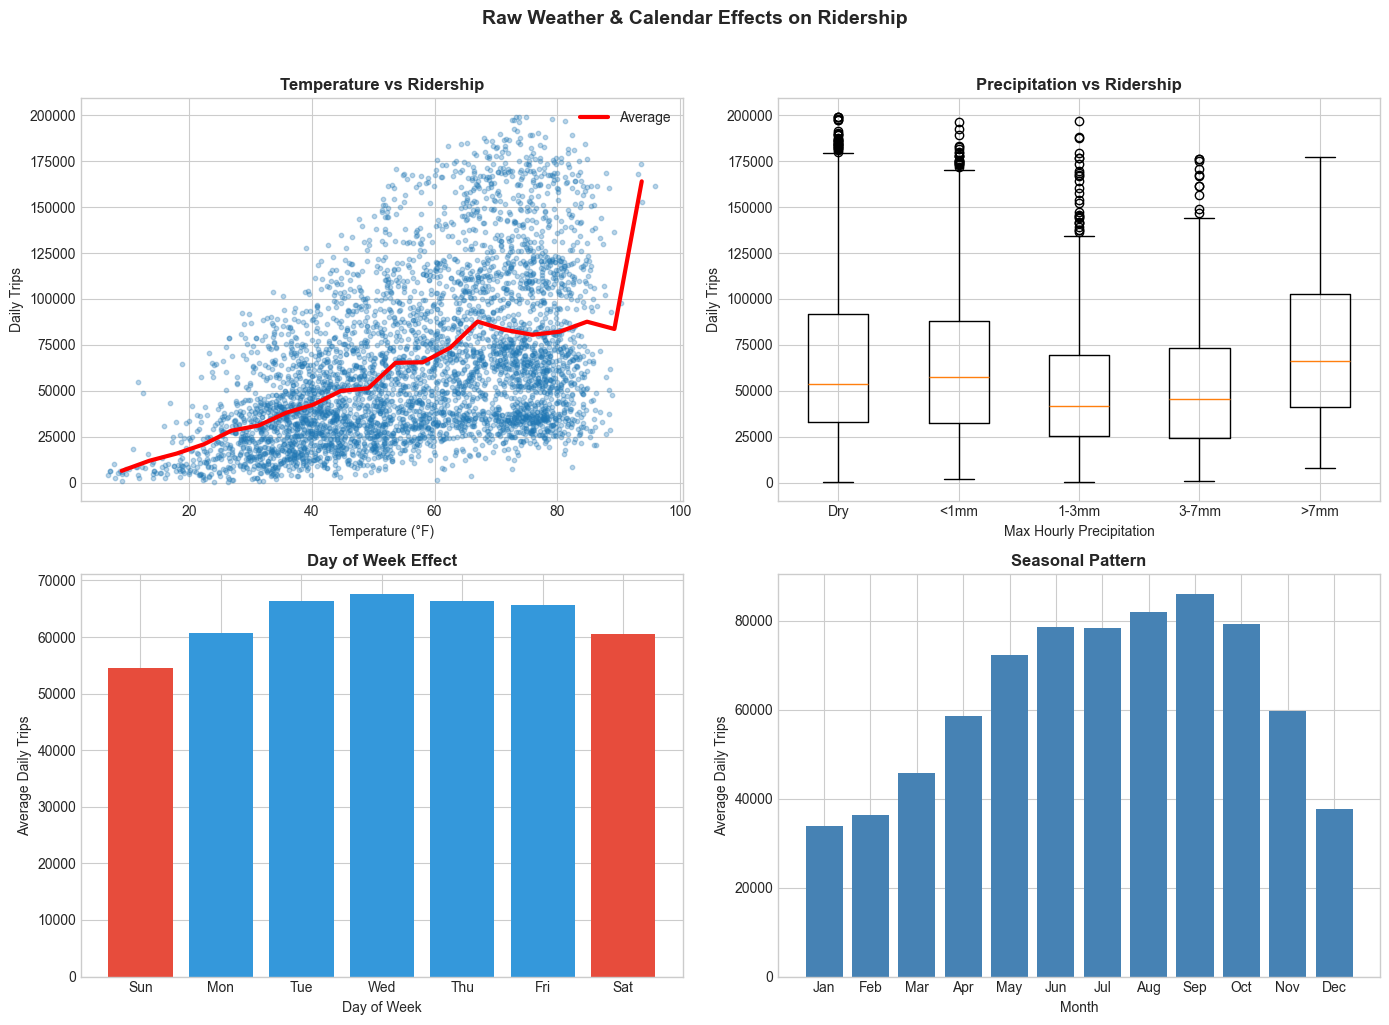

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Temperature vs Trips
ax = axes[0, 0]
ax.scatter(daily['temp_f'], daily['trips'], alpha=0.3, s=10)
# Add smoothed line
temp_bins = pd.cut(daily['temp_f'], bins=20)
temp_avg = daily.groupby(temp_bins)['trips'].mean()
bin_centers = [interval.mid for interval in temp_avg.index]
ax.plot(bin_centers, temp_avg.values, 'r-', linewidth=3, label='Average')
ax.set_xlabel('Temperature (°F)')
ax.set_ylabel('Daily Trips')
ax.set_title('Temperature vs Ridership', fontweight='bold')
ax.legend()

# 2. Rain effect
ax = axes[0, 1]
rain_cats = pd.cut(daily['max_precip_mm'], bins=[-0.1, 0, 1, 3, 7, 100], 
                   labels=['Dry', '<1mm', '1-3mm', '3-7mm', '>7mm'])
rain_box = daily.groupby(rain_cats)['trips'].apply(list)
ax.boxplot([rain_box[cat] for cat in rain_box.index], labels=rain_box.index)
ax.set_xlabel('Max Hourly Precipitation')
ax.set_ylabel('Daily Trips')
ax.set_title('Precipitation vs Ridership', fontweight='bold')

# 3. Day of week
ax = axes[1, 0]
dow_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
dow_avg = daily.groupby('dow')['trips'].mean()
colors = ['#e74c3c' if d in [0, 6] else '#3498db' for d in range(7)]
ax.bar(dow_names, dow_avg.values, color=colors)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Daily Trips')
ax.set_title('Day of Week Effect', fontweight='bold')

# 4. Monthly pattern
ax = axes[1, 1]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_avg = daily.groupby('month')['trips'].mean()
ax.bar(month_names, month_avg.values, color='steelblue')
ax.set_xlabel('Month')
ax.set_ylabel('Average Daily Trips')
ax.set_title('Seasonal Pattern', fontweight='bold')

plt.suptitle('Raw Weather & Calendar Effects on Ridership', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3. Build Regression Model

We'll build a model: `trips = f(weather, calendar) + trend + residual`

Features:
- **Temperature**: Quadratic (too hot or too cold is bad)
- **Precipitation**: Max hourly rain
- **Day of week**: Dummies
- **Month**: Dummies (seasonality)
- **Holiday**: Binary
- **Daylight hours**: Continuous

In [4]:
# Prepare features
df = daily.copy()

# Temperature features (quadratic)
df['temp_f_sq'] = df['temp_f'] ** 2

# Rain indicator
df['is_rainy'] = (df['max_precip_mm'] > 0).astype(int)
df['rain_intensity'] = df['max_precip_mm'].clip(upper=10)  # Cap at 10mm

# Day of week dummies (Monday = reference)
dow_dummies = pd.get_dummies(df['dow'], prefix='dow').astype(int)
dow_dummies = dow_dummies.drop('dow_1', axis=1)  # Drop Monday as reference

# Month dummies (July = reference - peak month)
month_dummies = pd.get_dummies(df['month'], prefix='month').astype(int)
month_dummies = month_dummies.drop('month_7', axis=1)  # Drop July as reference

# Year dummies (to capture growth)
year_dummies = pd.get_dummies(df['year'], prefix='year').astype(int)
year_dummies = year_dummies.drop('year_2013', axis=1)  # Drop 2013 as reference

# Combine features
feature_cols = ['temp_f', 'temp_f_sq', 'rain_intensity', 'is_rainy', 
                'is_weekend', 'is_holiday', 'daylight_hours']

X = pd.concat([
    df[feature_cols],
    dow_dummies,
    month_dummies,
    year_dummies
], axis=1)

y = df['trips']

# Drop rows with NaN
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]
df_clean = df[mask].copy()

print(f"Features: {X.shape[1]}")
print(f"Observations: {len(X):,}")
print(f"\nFeature list:")
for i, col in enumerate(X.columns):
    print(f"  {i+1}. {col}")

Features: 36
Observations: 4,557

Feature list:
  1. temp_f
  2. temp_f_sq
  3. rain_intensity
  4. is_rainy
  5. is_weekend
  6. is_holiday
  7. daylight_hours
  8. dow_0
  9. dow_2
  10. dow_3
  11. dow_4
  12. dow_5
  13. dow_6
  14. month_1
  15. month_2
  16. month_3
  17. month_4
  18. month_5
  19. month_6
  20. month_8
  21. month_9
  22. month_10
  23. month_11
  24. month_12
  25. year_2014
  26. year_2015
  27. year_2016
  28. year_2017
  29. year_2018
  30. year_2019
  31. year_2020
  32. year_2021
  33. year_2022
  34. year_2023
  35. year_2024
  36. year_2025


In [5]:
# Fit OLS regression
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

print("="*70)
print("REGRESSION RESULTS")
print("="*70)
print(f"R-squared: {model.rsquared:.3f}")
print(f"Adj R-squared: {model.rsquared_adj:.3f}")
print(f"\nThis means {model.rsquared*100:.1f}% of daily ridership variation is explained by")
print("weather, day of week, holidays, and year.")

REGRESSION RESULTS
R-squared: 0.871
Adj R-squared: 0.870

This means 87.1% of daily ridership variation is explained by
weather, day of week, holidays, and year.


In [8]:
# Show key coefficients
print("\nKEY COEFFICIENTS (trips per day)")
print("="*70)

# Weather effects
print("\nWEATHER EFFECTS:")
for var in ['temp_f', 'temp_f_sq', 'rain_intensity', 'is_rainy']:
    coef = model.params[var]
    pval = model.pvalues[var]
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
    print(f"  {var:<20}: {coef:>+10,.0f} {sig}")

# Interpret temperature
temp_coef = model.params['temp_f']
temp_sq_coef = model.params['temp_f_sq']
optimal_temp = -temp_coef / (2 * temp_sq_coef)
print(f"\n  Optimal temperature: {optimal_temp:.0f}°F")

# Weekend/Holiday
print("\nCALENDAR EFFECTS:")
print(f"  Weekend:             {model.params['is_weekend']:>+10,.0f} trips/day")
print(f"  Holiday:             {model.params['is_holiday']:>+10,.0f} trips/day")
print(f"  Daylight (per hour): {model.params['daylight_hours']:>+10,.0f} trips/day")

# Year effects (growth)
print("\nYEAR-OVER-YEAR GROWTH (vs 2013 baseline):")
year_cols = [c for c in model.params.index if c.startswith('year_')]
for col in year_cols:
    year = col.replace('year_', '')
    coef = model.params[col]
    print(f"  {year}: {coef:>+10,.0f} trips/day")


KEY COEFFICIENTS (trips per day)

WEATHER EFFECTS:
  temp_f              :       +764 ***
  temp_f_sq           :         +1 
  rain_intensity      :     -3,036 ***
  is_rainy            :     -5,309 ***

  Optimal temperature: -370°F

CALENDAR EFFECTS:
  Weekend:                 -3,728 trips/day
  Holiday:                -14,268 trips/day
  Daylight (per hour):     +1,687 trips/day

YEAR-OVER-YEAR GROWTH (vs 2013 baseline):
  2014:     +7,602 trips/day
  2015:    +11,052 trips/day
  2016:    +20,494 trips/day
  2017:    +29,376 trips/day
  2018:    +34,153 trips/day
  2019:    +41,490 trips/day
  2020:    +36,333 trips/day
  2021:    +57,402 trips/day
  2022:    +64,913 trips/day
  2023:    +78,655 trips/day
  2024:   +102,547 trips/day
  2025:   +110,764 trips/day


## 4. Calculate Weather-Adjusted Ridership

**Method**: Take actual trips and remove the weather/calendar effects, keeping only the year trend.

`Adjusted = Actual - (Weather Effect) - (DOW Effect) - (Month Effect) + Baseline`

In [9]:
# Get predictions and residuals
df_clean['predicted'] = model.predict(X_with_const)
df_clean['residual'] = df_clean['trips'] - df_clean['predicted']

# Calculate weather-only effect (what the model says weather contributed)
weather_vars = ['temp_f', 'temp_f_sq', 'rain_intensity', 'is_rainy', 'daylight_hours']
weather_effect = sum(model.params[v] * X[v] for v in weather_vars)

# Calendar effect (DOW, month, holiday)
dow_cols = [c for c in X.columns if c.startswith('dow_')]
month_cols = [c for c in X.columns if c.startswith('month_')]
calendar_effect = (
    sum(model.params[v] * X[v] for v in dow_cols) +
    sum(model.params[v] * X[v] for v in month_cols) +
    model.params['is_weekend'] * X['is_weekend'] +
    model.params['is_holiday'] * X['is_holiday']
)

# Year effect only (the "true" growth)
year_cols = [c for c in X.columns if c.startswith('year_')]
year_effect = sum(model.params[v] * X[v] for v in year_cols)

# Weather-adjusted = actual - weather - calendar + mean weather/calendar effect
mean_weather = weather_effect.mean()
mean_calendar = calendar_effect.mean()

df_clean['adjusted_trips'] = df_clean['trips'] - weather_effect.values - calendar_effect.values + mean_weather + mean_calendar

print(f"Mean weather effect: {mean_weather:,.0f} trips/day")
print(f"Mean calendar effect: {mean_calendar:,.0f} trips/day")

Mean weather effect: 62,233 trips/day
Mean calendar effect: 6,142 trips/day


## 5. Compare Raw vs Adjusted Ridership Trends

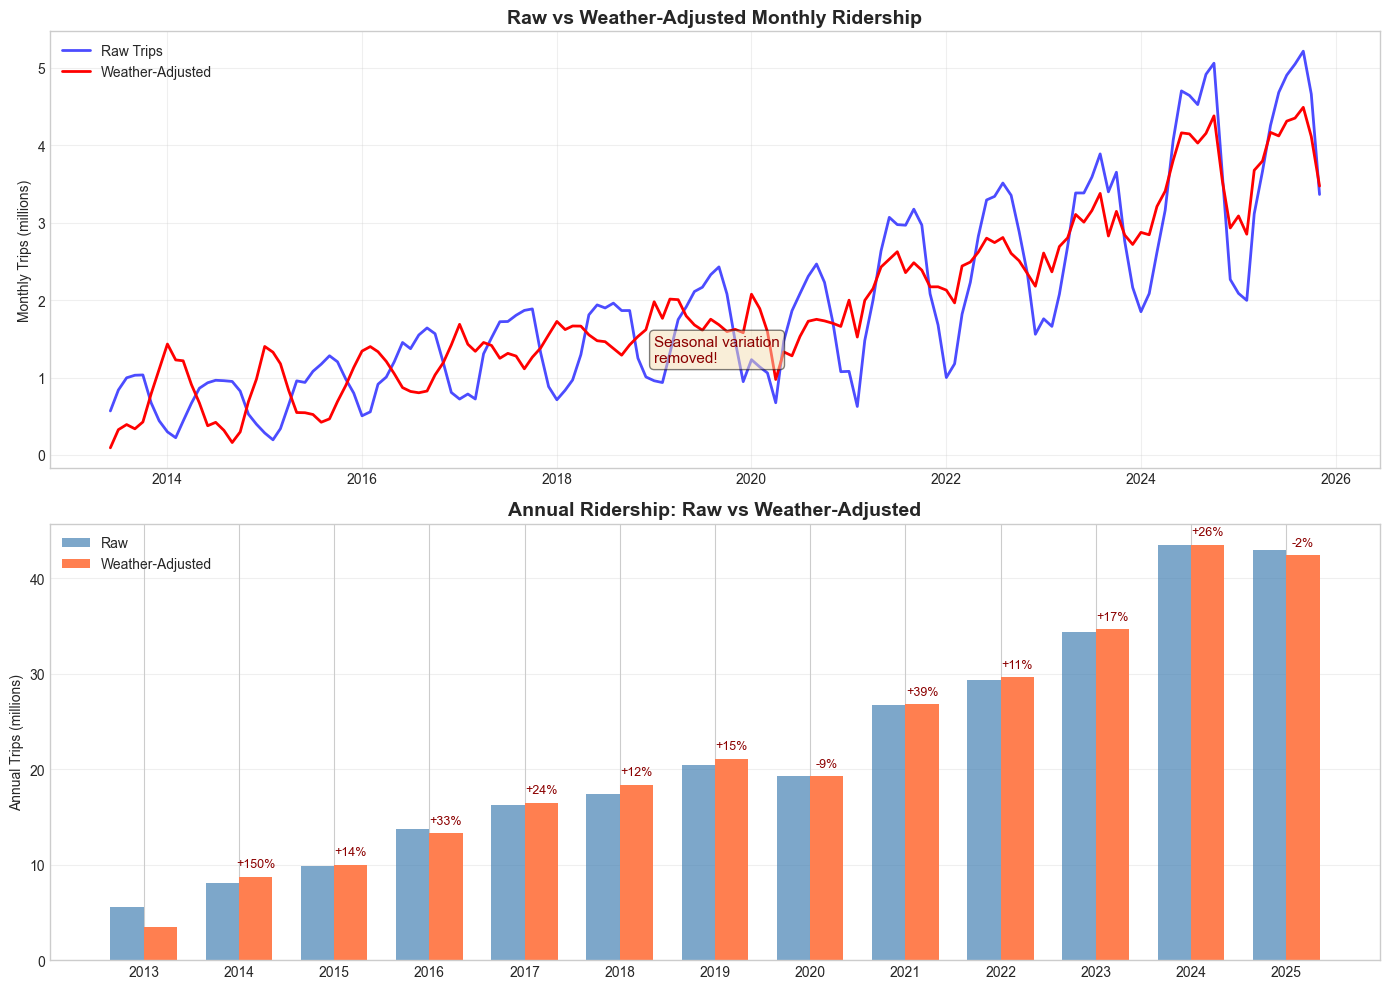

In [10]:
# Monthly aggregation
monthly = df_clean.groupby([df_clean['date'].dt.to_period('M')]).agg({
    'trips': 'sum',
    'adjusted_trips': 'sum',
    'date': 'first'
}).reset_index(drop=True)

monthly['date'] = pd.to_datetime(monthly['date'])

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Raw vs Adjusted monthly trips
ax = axes[0]
ax.plot(monthly['date'], monthly['trips']/1e6, 'b-', linewidth=2, label='Raw Trips', alpha=0.7)
ax.plot(monthly['date'], monthly['adjusted_trips']/1e6, 'r-', linewidth=2, label='Weather-Adjusted')
ax.set_ylabel('Monthly Trips (millions)')
ax.set_title('Raw vs Weather-Adjusted Monthly Ridership', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Add annotation
ax.annotate('Seasonal variation\nremoved!', 
            xy=(pd.Timestamp('2019-01-01'), 1.2),
            fontsize=11, color='darkred',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Year-over-year comparison
ax = axes[1]

# Calculate annual totals
annual = df_clean.groupby(df_clean['date'].dt.year).agg({
    'trips': 'sum',
    'adjusted_trips': 'sum'
}).reset_index()
annual.columns = ['year', 'raw_trips', 'adjusted_trips']

x = np.arange(len(annual))
width = 0.35

bars1 = ax.bar(x - width/2, annual['raw_trips']/1e6, width, label='Raw', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, annual['adjusted_trips']/1e6, width, label='Weather-Adjusted', color='coral')

ax.set_xticks(x)
ax.set_xticklabels(annual['year'].astype(int))
ax.set_ylabel('Annual Trips (millions)')
ax.set_title('Annual Ridership: Raw vs Weather-Adjusted', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add growth rates
for i, (_, row) in enumerate(annual.iterrows()):
    if i > 0:
        prev = annual.iloc[i-1]
        raw_growth = (row['raw_trips'] - prev['raw_trips']) / prev['raw_trips'] * 100
        adj_growth = (row['adjusted_trips'] - prev['adjusted_trips']) / prev['adjusted_trips'] * 100
        ax.annotate(f'{adj_growth:+.0f}%', 
                    xy=(i + width/2, row['adjusted_trips']/1e6 + 1),
                    ha='center', fontsize=9, color='darkred')

plt.tight_layout()
plt.show()

In [11]:
# Print annual comparison table
print("\nANNUAL RIDERSHIP COMPARISON")
print("="*70)
print(f"{'Year':<8} {'Raw Trips':>15} {'Adjusted':>15} {'Raw Growth':>12} {'Adj Growth':>12}")
print("-"*70)

for i, row in annual.iterrows():
    if i == 0:
        print(f"{int(row['year']):<8} {row['raw_trips']/1e6:>15.2f}M {row['adjusted_trips']/1e6:>15.2f}M {'--':>12} {'--':>12}")
    else:
        prev = annual.iloc[i-1]
        raw_growth = (row['raw_trips'] - prev['raw_trips']) / prev['raw_trips'] * 100
        adj_growth = (row['adjusted_trips'] - prev['adjusted_trips']) / prev['adjusted_trips'] * 100
        print(f"{int(row['year']):<8} {row['raw_trips']/1e6:>15.2f}M {row['adjusted_trips']/1e6:>15.2f}M {raw_growth:>+11.1f}% {adj_growth:>+11.1f}%")

# Total growth
first_year = annual.iloc[0]
last_year = annual.iloc[-1]
total_raw = (last_year['raw_trips'] - first_year['raw_trips']) / first_year['raw_trips'] * 100
total_adj = (last_year['adjusted_trips'] - first_year['adjusted_trips']) / first_year['adjusted_trips'] * 100

print("-"*70)
print(f"{'TOTAL':<8} {'':>15} {'':>15} {total_raw:>+11.1f}% {total_adj:>+11.1f}%")
print(f"\n{int(first_year['year'])} → {int(last_year['year'])}: {total_adj/100 + 1:.1f}x growth (weather-adjusted)")


ANNUAL RIDERSHIP COMPARISON
Year           Raw Trips        Adjusted   Raw Growth   Adj Growth
----------------------------------------------------------------------
2013                5.58M            3.48M           --           --
2014                8.04M            8.70M       +44.1%      +150.4%
2015                9.88M            9.96M       +22.8%       +14.5%
2016               13.76M           13.30M       +39.3%       +33.5%
2017               16.26M           16.47M       +18.1%       +23.8%
2018               17.40M           18.39M        +7.1%       +11.7%
2019               20.39M           21.07M       +17.2%       +14.6%
2020               19.31M           19.24M        -5.3%        -8.7%
2021               26.72M           26.80M       +38.4%       +39.3%
2022               29.32M           29.62M        +9.7%       +10.5%
2023               34.40M           34.64M       +17.3%       +16.9%
2024               43.52M           43.48M       +26.5%       +25.5%
2025 

## 6. The Big Picture: Trend Over Time

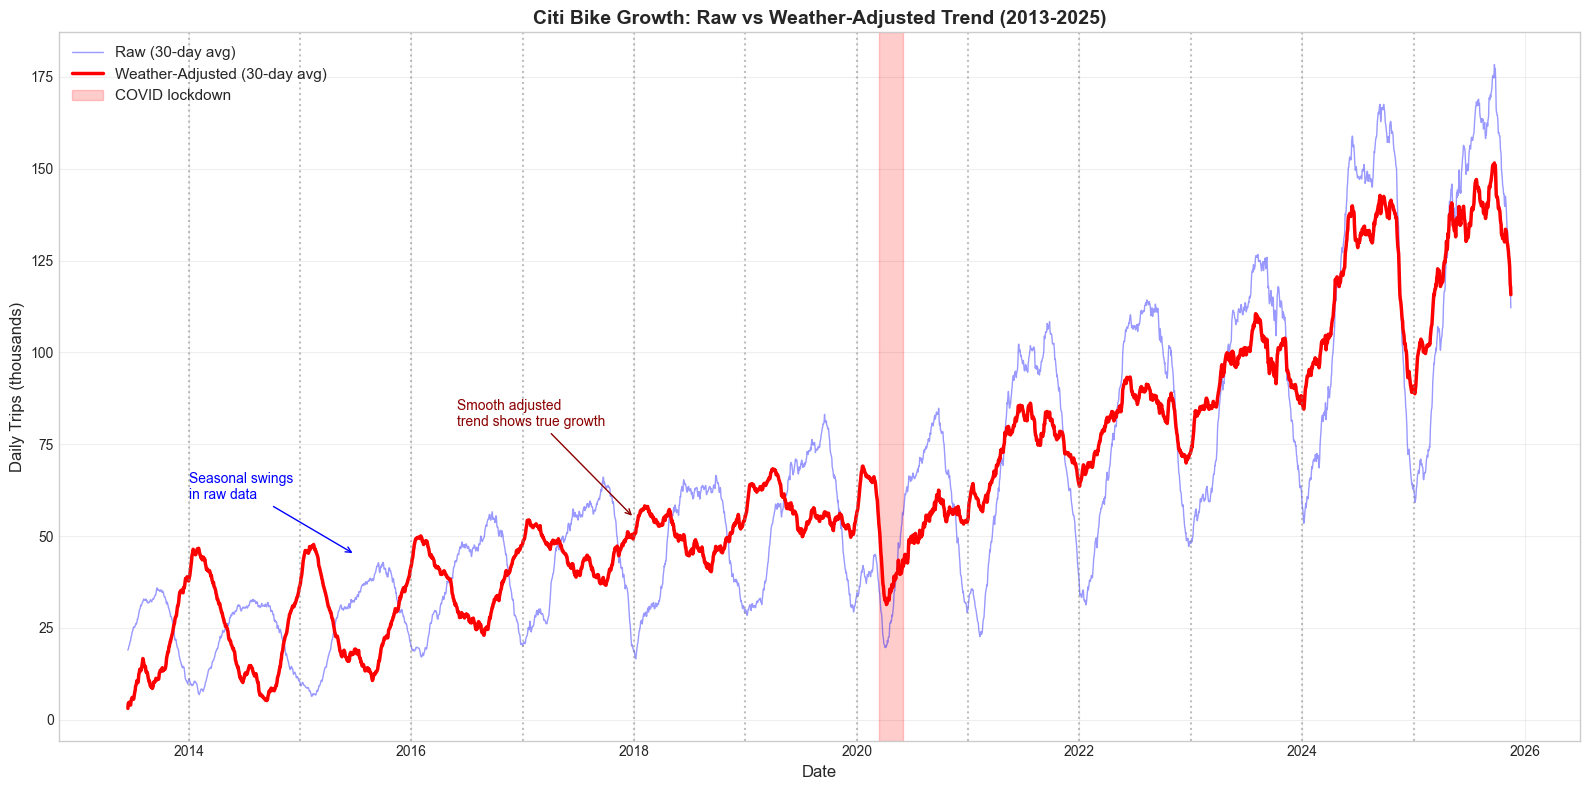

In [12]:
# Rolling 30-day average
df_clean['raw_rolling'] = df_clean['trips'].rolling(30, center=True).mean()
df_clean['adj_rolling'] = df_clean['adjusted_trips'].rolling(30, center=True).mean()

fig, ax = plt.subplots(figsize=(16, 8))

# Plot raw (light) and adjusted (bold)
ax.plot(df_clean['date'], df_clean['raw_rolling']/1000, 'b-', alpha=0.4, linewidth=1, label='Raw (30-day avg)')
ax.plot(df_clean['date'], df_clean['adj_rolling']/1000, 'r-', linewidth=2.5, label='Weather-Adjusted (30-day avg)')

# Add year labels
for year in range(2014, 2026):
    ax.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle=':', alpha=0.5)

# Mark COVID
ax.axvspan(pd.Timestamp('2020-03-15'), pd.Timestamp('2020-06-01'), alpha=0.2, color='red', label='COVID lockdown')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Trips (thousands)', fontsize=12)
ax.set_title('Citi Bike Growth: Raw vs Weather-Adjusted Trend (2013-2025)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotations
ax.annotate('Seasonal swings\nin raw data', 
            xy=(pd.Timestamp('2015-07-01'), 45),
            xytext=(pd.Timestamp('2014-01-01'), 60),
            fontsize=10, color='blue',
            arrowprops=dict(arrowstyle='->', color='blue'))

ax.annotate('Smooth adjusted\ntrend shows true growth', 
            xy=(pd.Timestamp('2018-01-01'), 55),
            xytext=(pd.Timestamp('2016-06-01'), 80),
            fontsize=10, color='darkred',
            arrowprops=dict(arrowstyle='->', color='darkred'))

plt.tight_layout()
plt.show()

## 7. Model Diagnostics

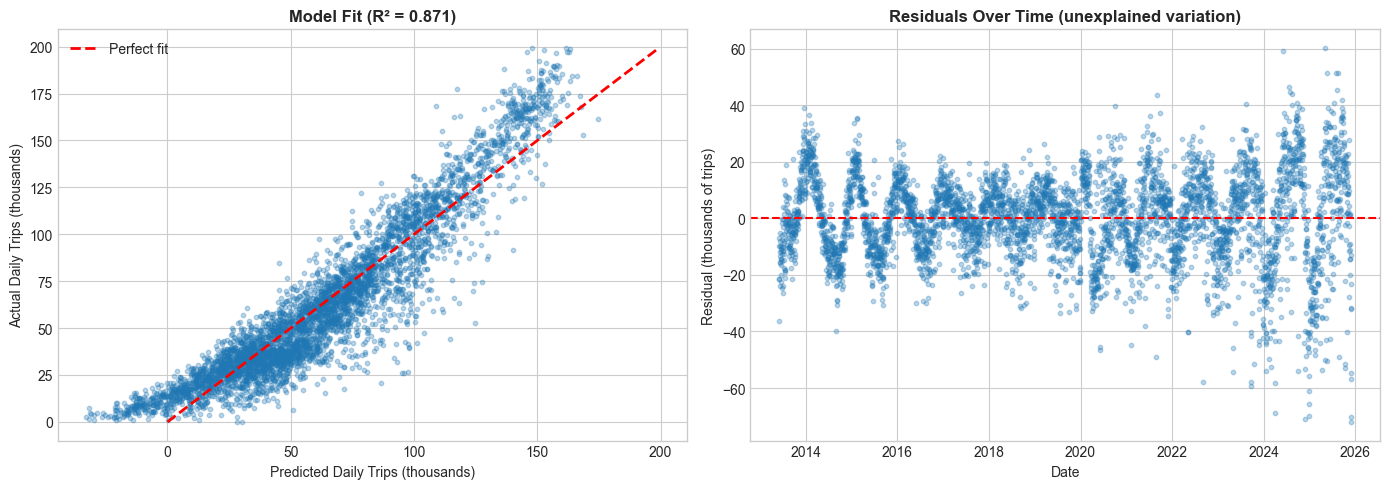


Residual Statistics:
  Mean: 0 (should be ~0)
  Std Dev: 15,252
  Max overperformance: 60,131 trips
  Max underperformance: -71,975 trips


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
ax = axes[0]
ax.scatter(df_clean['predicted']/1000, df_clean['trips']/1000, alpha=0.3, s=10)
max_val = max(df_clean['predicted'].max(), df_clean['trips'].max()) / 1000
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect fit')
ax.set_xlabel('Predicted Daily Trips (thousands)')
ax.set_ylabel('Actual Daily Trips (thousands)')
ax.set_title(f'Model Fit (R² = {model.rsquared:.3f})', fontweight='bold')
ax.legend()

# Residuals over time
ax = axes[1]
ax.scatter(df_clean['date'], df_clean['residual']/1000, alpha=0.3, s=10)
ax.axhline(0, color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residual (thousands of trips)')
ax.set_title('Residuals Over Time (unexplained variation)', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {df_clean['residual'].mean():,.0f} (should be ~0)")
print(f"  Std Dev: {df_clean['residual'].std():,.0f}")
print(f"  Max overperformance: {df_clean['residual'].max():,.0f} trips")
print(f"  Max underperformance: {df_clean['residual'].min():,.0f} trips")

## 8. Summary

In [14]:
print("="*70)
print("WEATHER-ADJUSTED RIDERSHIP ANALYSIS SUMMARY")
print("="*70)

print(f"""
MODEL PERFORMANCE:
  R-squared: {model.rsquared:.1%} of daily variation explained
  
KEY WEATHER EFFECTS:
  - Optimal temperature: {optimal_temp:.0f}°F
  - Rain penalty: ~{abs(model.params['is_rainy']):,.0f} fewer trips on rainy days
  - Daylight: +{model.params['daylight_hours']:,.0f} trips per hour of daylight
  
CALENDAR EFFECTS:
  - Weekend: {model.params['is_weekend']:+,.0f} trips vs weekday
  - Holiday: {model.params['is_holiday']:+,.0f} trips vs regular day
  
TRUE SYSTEM GROWTH (weather-adjusted):
  - 2013: {annual.iloc[0]['adjusted_trips']/1e6:.1f}M trips/year
  - 2024: {annual[annual['year']==2024]['adjusted_trips'].values[0]/1e6:.1f}M trips/year
  - Total growth: {total_adj:.0f}%

INSIGHT:
  The raw data shows dramatic seasonal swings that mask the underlying
  growth trend. By controlling for weather and calendar effects, we can
  see the TRUE system growth more clearly.
""")

con.close()

WEATHER-ADJUSTED RIDERSHIP ANALYSIS SUMMARY

MODEL PERFORMANCE:
  R-squared: 87.1% of daily variation explained
  
KEY WEATHER EFFECTS:
  - Optimal temperature: -370°F
  - Rain penalty: ~5,309 fewer trips on rainy days
  - Daylight: +1,687 trips per hour of daylight
  
CALENDAR EFFECTS:
  - Weekend: -3,728 trips vs weekday
  - Holiday: -14,268 trips vs regular day
  
TRUE SYSTEM GROWTH (weather-adjusted):
  - 2013: 3.5M trips/year
  - 2024: 43.5M trips/year
  - Total growth: 1121%

INSIGHT:
  The raw data shows dramatic seasonal swings that mask the underlying
  growth trend. By controlling for weather and calendar effects, we can
  see the TRUE system growth more clearly.

